Датасет https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

## Загрузка библиотек, данных и первичная оработка 

In [2]:
#Импорт библиотек
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
plt.style.use(['dark_background'])
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
# загрузка данных
data = pd.read_csv('car.data')
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
data.shape

(1728, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
#судя по описанию на сайте, датасет предствляет из себя описание признаков эвакуированных машин
#классов машин всего 4 unacc, acc, good, vgood, так как они идут от наихудшего к наилучшему
#, то можно их пронумеровть от 1 до 4
# аналогично можно поступить с категориальными перемерменными buting, maint и lug_bust

In [7]:
data['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

In [8]:
data['buying'].value_counts()

med      432
low      432
vhigh    432
high     432
Name: buying, dtype: int64

In [9]:
data['doors'].value_counts()

4        432
2        432
3        432
5more    432
Name: doors, dtype: int64

In [10]:
# заменю 5more просто на 5, так как рапределение пропорциональное и получу в итоге поде с числом
data['doors'] = data['doors'].str.replace('5more','5')
data['doors']= data['doors'].astype(int)


In [11]:
data['persons'].value_counts()

4       576
2       576
more    576
Name: persons, dtype: int64

In [12]:
data['persons'] = data['persons'].str.replace('more','5')
data['persons']= data['persons'].astype(int)

In [13]:
data['maint'].value_counts()

med      432
low      432
vhigh    432
high     432
Name: maint, dtype: int64

In [14]:
data['lug_boot'].value_counts()

med      576
small    576
big      576
Name: lug_boot, dtype: int64

In [15]:
data['safety'].value_counts()

med     576
low     576
high    576
Name: safety, dtype: int64

In [16]:
# видно, что пример учебный, так как признаки распредлены равномерно по категориям,
# в реальной жизни такое очень редко встречается

In [17]:
def safety_map(label):
    if  label == 'low':
        return 1
    if  label == 'med':
        return 2
    else:
        return 3
def lug_boot_map(label):
    if  label == 'small':
        return 1
    if  label == 'med':
        return 2
    else:
        return 3
def maint_map(label):
    if  label == 'low':
        return 1
    if  label == 'med':
        return 2
    if  label == 'high':
        return 3
    else:
        return 4
def buying_map(label):
    if  label == 'low':
        return 1
    if  label == 'med':
        return 2
    if  label == 'high':
        return 3
    else:
        return 4
def class_map(label):
    if  label == 'unacc':
        return 1
    if  label == 'acc':
        return 2
    if  label == 'good':
        return 3
    else:
        return 4
        

In [18]:
data['safety'] = data['safety'].apply(lambda x :safety_map(x))
data['lug_boot'] = data['lug_boot'].apply(lambda x :lug_boot_map(x))
data['maint'] = data['maint'].apply(lambda x :maint_map(x))
data['buying'] = data['buying'].apply(lambda x :buying_map(x))
data['class'] = data['class'].apply(lambda x :class_map(x))
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


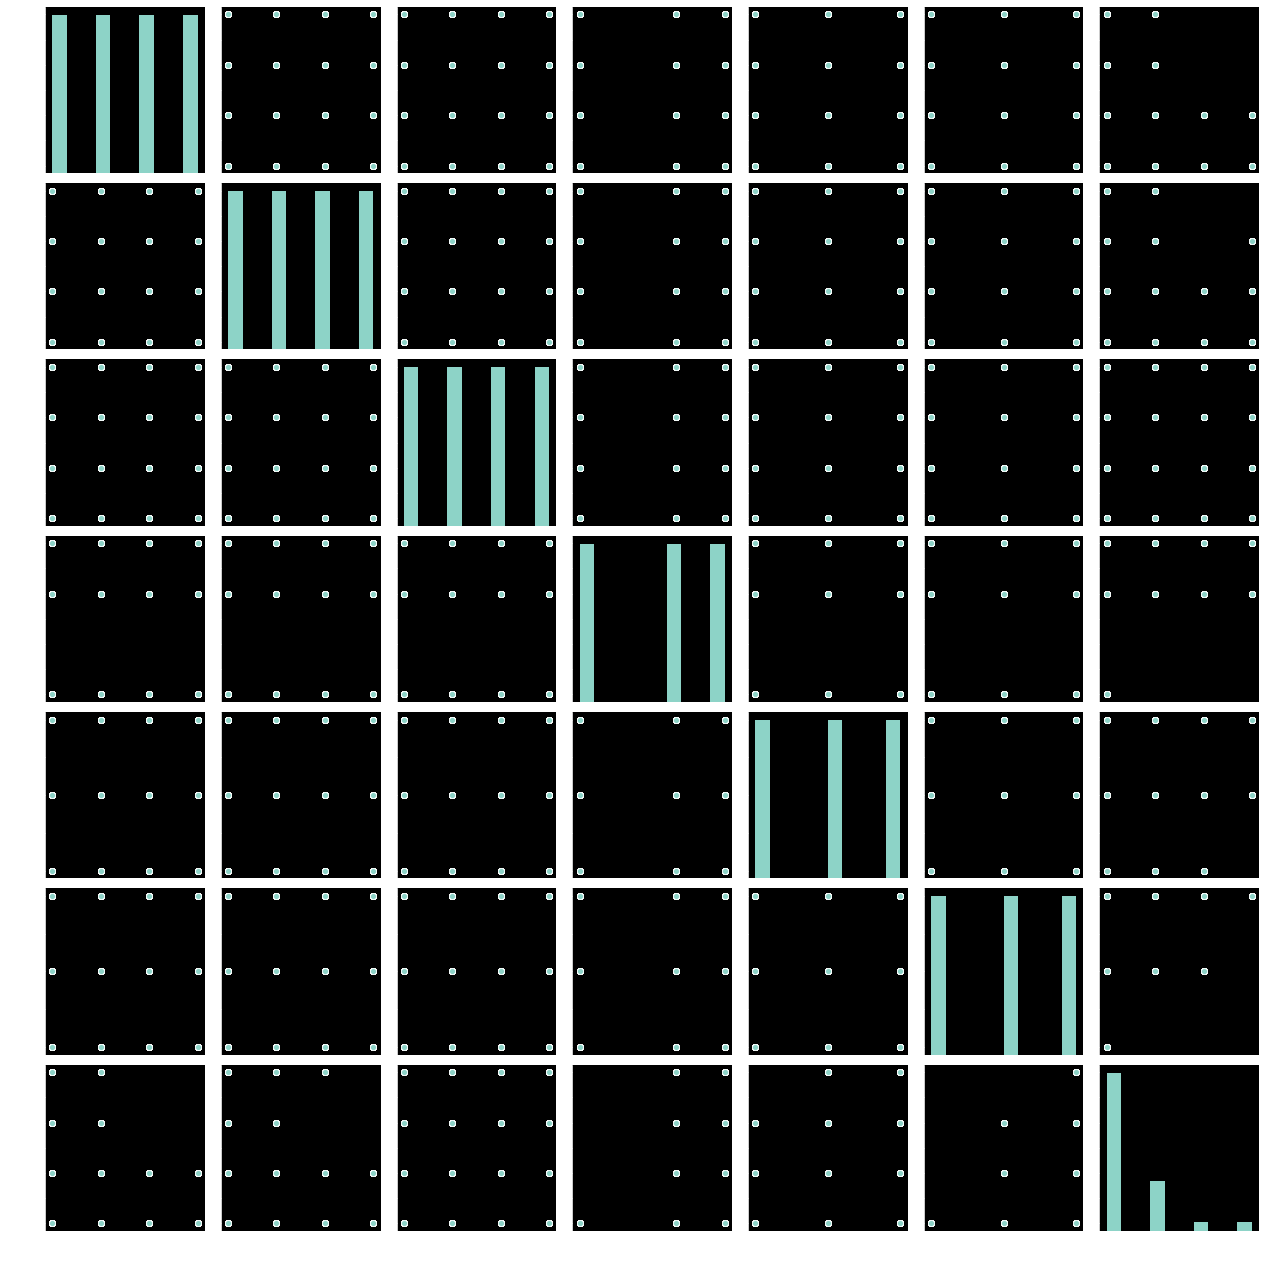

In [19]:
#подтверждение того, что данные придуманные
sns.pairplot(data)

## Выделение кластеров

### K_Means

In [20]:
from sklearn.cluster import KMeans
from sklearn import metrics

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

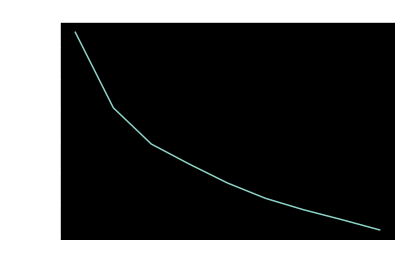

In [21]:
X = data.drop(columns = ['class'])
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(km.inertia_)
 
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

[0.21941278870743927, 0.1810315817867395, 0.1587940454110574, 0.16694756970283742, 0.16931962094918032, 0.16482011996305418, 0.165759464253836, 0.167112655312417]


Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

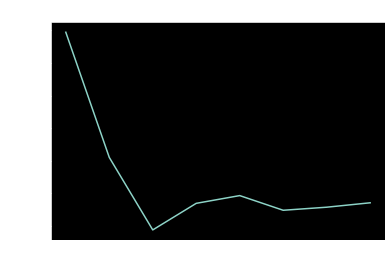

In [22]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(silhouette_score(X, km.labels_))

print(inertia)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [26]:
# по графику инерции видно, что оптимальное кол-во кластеров 4
data['clstrs_kmeans'] = KMeans(n_clusters=4).fit(X).labels_
data.head()

,buying,maint,doors,persons,lug_boot,safety,class,clasters,clstrs_kmeans
0,4,4,2,2,1,1,1,0,1
1,4,4,2,2,1,2,1,0,1
2,4,4,2,2,1,3,1,0,1
3,4,4,2,2,2,1,1,0,1
4,4,4,2,2,2,2,1,0,1


In [27]:
# проверка соответствия выделенных кластеров и классов датаеста
pd.crosstab(index= data['class'], columns = data.clstrs_kmeans)

clstrs_kmeans,0,1,2,3
class,,,,
1,254,576,216,164
2,101,0,160,123
3,0,0,24,45
4,5,0,32,28


### AgglomerativeClustering

In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='centroid', metric='euclidean')


In [33]:
plt.rcParams["figure.figsize"] = [12, 8]

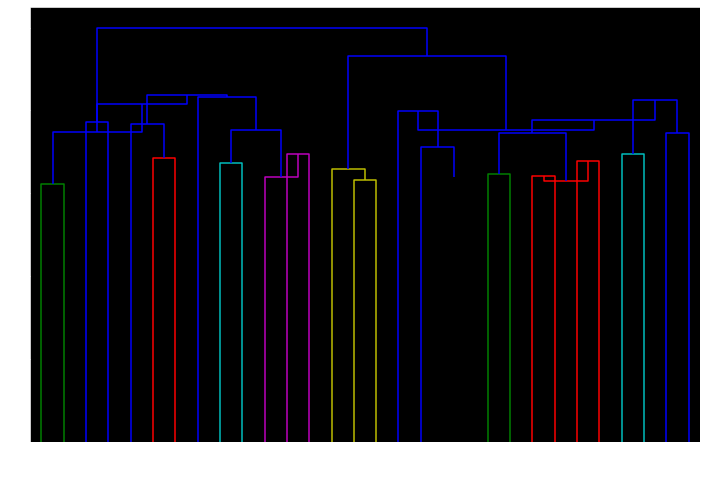

In [34]:
fig, ax = plt.subplots(1, 1)
dend = dendrogram(Z, ax=ax, truncate_mode='lastp')

In [36]:
agg_cl = AgglomerativeClustering(n_clusters = 4).fit(X) 
data['aggl_cl'] = agg_cl.labels_
pd.crosstab(index= data['class'], columns = data.clstrs_kmeans)

clstrs_kmeans,0,1,2,3
class,,,,
1,254,576,216,164
2,101,0,160,123
3,0,0,24,45
4,5,0,32,28


### DBScan

In [39]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# Compute DBSCAN
db = DBSCAN(eps=0.3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 1728


Из-за того, что данные учебные, все точки находятся примерно на одинаковом расстояниии друг от друга и DBScan считает их шумом. Попробую проскалировать и попробовать все-таки что-то найти изменяя расстояние между кластерами

In [50]:
from sklearn.preprocessing import StandardScaler # for feature scaling
X_sc = StandardScaler().fit_transform(X)

In [51]:
# Compute DBSCAN
db = DBSCAN(eps=0.3).fit(X_sc)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 1728


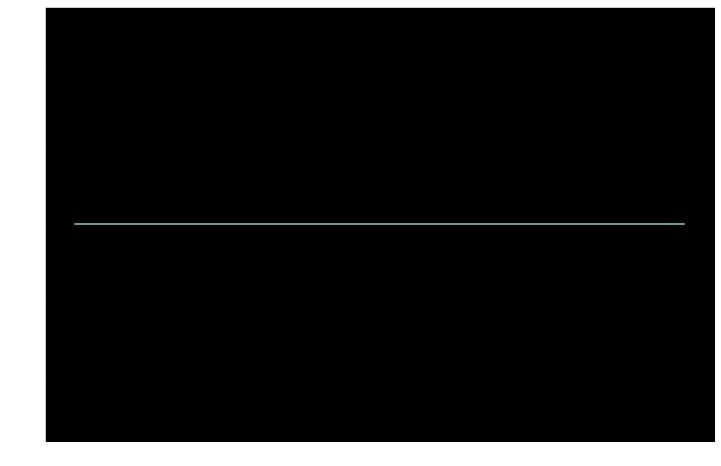

In [56]:
i = np.linspace(0.1, 20.0, 200)
arr_clasters = []
for j in i:
    db = DBSCAN(eps=j).fit(X_sc)
    arr_clasters.append(len(set(labels)) - (1 if -1 in labels else 0))
plt.plot(arr_clasters)

Ничего не изменилось, кластеров не обнаружено, попробую применить PCA, чтобы оставить только 2 измерения для визуализации и еще одной попытки выделить кластеры

In [61]:
from sklearn.decomposition import PCA

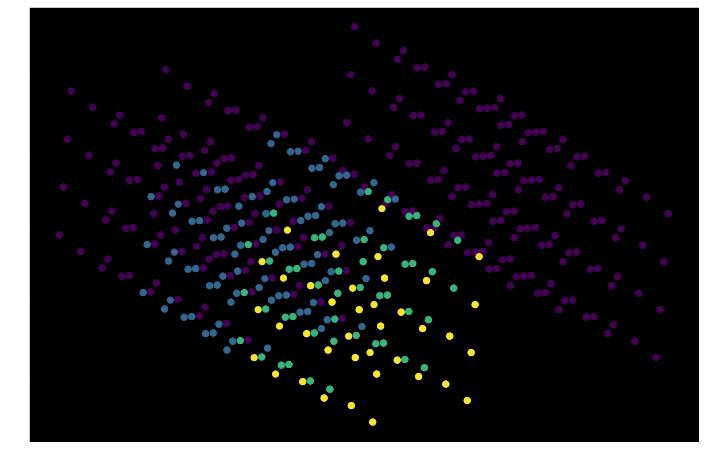

In [72]:
pca = PCA()
X_new = PCA(n_components=2).fit_transform(X_sc)
plt.scatter(X_new[:, 0], X_new[:, 1], c=data['class'])

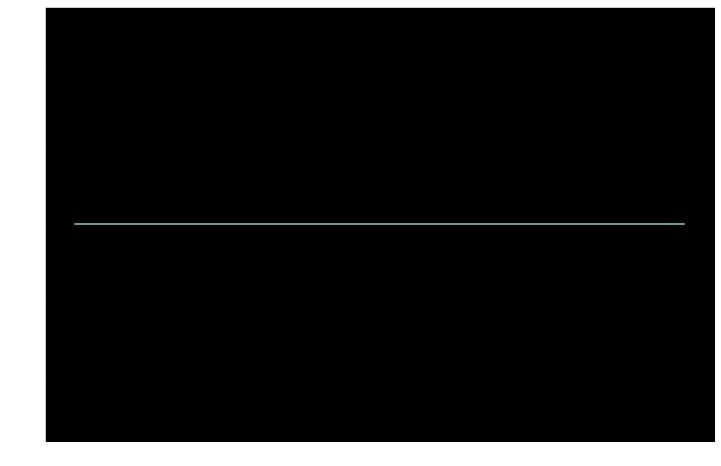

In [73]:
i = np.linspace(0.1, 20.0, 200)
arr_clasters = []
for j in i:
    db = DBSCAN(eps=j).fit(X_new)
    arr_clasters.append(len(set(labels)) - (1 if -1 in labels else 0))
plt.plot(arr_clasters)

Хотя визуально кажется, что кластеры все-таки есть, для DBScan ничего не изменилось

## Выводы

1. Модель K-means достаточно точно выдела 4 кластера, что соответствует классам машин в датасете
2. Кластеры очень неточно попадают в классы машин, например в 1 классе равномерно распределено аж 4 кластера
3. Модель иерархической кластеризации ничего принцпиально нового не привнесла
4. Модель DBScan не обнаружила кластеров, так как ищет по плотности наблюдений, а данные в датасете учебные и точки расположены примерно на одинковов расстоянии